### Human in the loop

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="llama-3.1-8b-instant")
result=llm.invoke("Hello")
result

AIMessage(content='Hello. What would you like to talk about or ask?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 36, 'total_tokens': 49, 'completion_time': 0.025389152, 'completion_tokens_details': None, 'prompt_time': 0.001728596, 'prompt_tokens_details': None, 'queue_time': 0.047631184, 'total_time': 0.027117748}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c76b8-e505-7e72-b2cb-0b341a2a3ff9-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 36, 'output_tokens': 13, 'total_tokens': 49})

In [2]:
### Custome tools

def multiply(a:int,b:int)->int:
    """ Multiple a and b
    Args
    a:first int
    b:second int 
    """

    return a*b


def add(a:int,b:int)->int:
    """ Add a and b
    Args
    a:first int 
    b:second int 
    """
    return a+b

def divide(a:int,b:int)->int:
    """ divide a and b
    Args
    a:first int
    b: second int
    """
    return a/b

tools=[add,multiply,divide]
tools

[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> int>]

In [4]:
### Integrate tools with llm
llm_with_tools=llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x0000021DFA79D100>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000021DFA5755B0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Add a and b\nArgs\na:first int \nb:second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiple a and b\nArgs\na:first int\nb:second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'ty

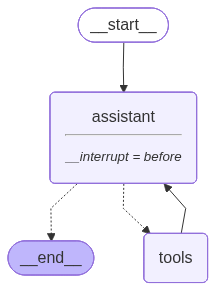

In [10]:
### Workflow with langgraph

from IPython.display import Image,display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START,StateGraph
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

### system Message
sys_msg=SystemMessage(content="You are helpful assistant tasked with performing arithmetic on a set of inputs.")

### node
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

#Graph
builder=StateGraph(MessagesState)

## Define nodes:
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

## Define the Edges

builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)

builder.add_edge("tools","assistant")
memory=MemorySaver()

#human in the loop
graph=builder.compile(interrupt_before=["assistant"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
thread={"configurable":{"thread_id":"123"}}
initial_input={"messages":HumanMessage(content="Multiply 2 and 4")}

In [12]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event ['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 4


In [14]:
state=graph.get_state(thread)
state.next

('assistant',)

In [ ]:
## continue the execution to assistant
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 4
================================== Ai Message ==================================
Tool Calls:
  multiply (jcr3rphsq)
 Call ID: jcr3rphsq
  Args:
    a: 2
    b: 4
================================= Tool Message =================================
Name: multiply

8


In [ ]:
## continue the execution of assistant and then end
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

8
================================== Ai Message ==================================

The result of multiplying 2 and 4 is 8.


### Edit Human Feedback

In [24]:
thread={"configurable":{"thread_id":"2"}}
initial_input={"messages":HumanMessage(content="Multiply 2 and 4")}
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event ['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 4


In [25]:
state=graph.get_state(thread)
state.next

('assistant',)

In [26]:
graph.update_state(thread,{"messages":[HumanMessage(content="No, please multiply 15 and 6")]})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f10dbba-6385-6a9f-8001-26d56d72c159'}}

In [27]:
new_state=graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 4
================================ Human Message =================================

No, please multiply 15 and 6


In [29]:
for event in graph.stream(None,thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, please multiply 15 and 6
================================== Ai Message ==================================

<multiply>{"a": 15, "b": 6}</multiply>


In [30]:
for event in graph.stream(None,thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

<multiply>{"a": 15, "b": 6}</multiply>


## Workflow will wait for the User Input

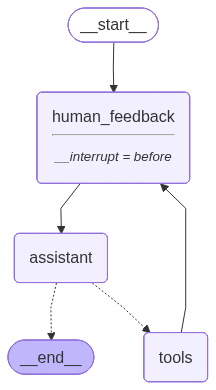

In [31]:
#System Message
sys_msg=SystemMessage(content="You are a helpful assistant yasked with performing arithmetic on a set of inputs. ")

### Human feedback node

def human_feedback(state:MessagesState):
    pass

### Assistant node
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+ state["messages"])]}

# Graph
builder=StateGraph(MessagesState)

#Define nodes:these do the work
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_node("human_feedback",human_feedback)


## Define the edges
builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
    )
builder.add_edge("tools","human_feedback")

memory=MemorySaver()
graph=builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))



In [33]:
initial_input={"messages": " Multiply 2 and 3"}
thread={"configurable":{"thread_id":"5"}}

for event in graph.stream(initial_input,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

## get user input
user_input=input("Tell me how you want to update the state:")
graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

# Continue the graph execution 
for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

 Multiply 2 and 3
================================ Human Message =================================

please multiply 8 and 7
================================== Ai Message ==================================

<multiply>{"a": 8, "b": 7}</multiply>


In [34]:
# Continue the graph execution 
for event in graph.stream(None,thread,stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

<multiply>{"a": 8, "b": 7}</multiply>


### add interuupt anywhere you want

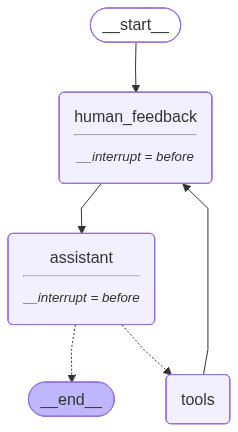

In [35]:
#System Message
sys_msg=SystemMessage(content="You are a helpful assistant yasked with performing arithmetic on a set of inputs. ")

### Human feedback node

def human_feedback(state:MessagesState):
    pass

### Assistant node
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+ state["messages"])]}

# Graph
builder=StateGraph(MessagesState)

#Define nodes:these do the work
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_node("human_feedback",human_feedback)


## Define the edges
builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
    )
builder.add_edge("tools","human_feedback")

memory=MemorySaver()
graph=builder.compile(interrupt_before=["human_feedback","assistant"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

